# Doublet detection

```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: surface-protein-doublet-detection-key-takeaway-1
:link-type: ref
Heterotypic doublets in ADT data can be identified and removed using mutually exclusive cell type markers (e.g., CD3, CD19, CD14), with cells expressing both markers likely representing doublets.
:::

```

<!-- START ENV-SETUP -->
``````{dropdown} <i class="fa-solid fa-gear"></i>   Environment setup
`````{tab-set}

````{tab-item} Steps
```{include} ../_static/default_text_env_setup.md
```
````

````{tab-item} yml
```{literalinclude} surface_protein.yml
:language: yaml
```
````

`````
``````
<!-- END ENV-SETUP -->

(surface-protein-doublet-detection-key-takeaway-1)=
## Motivation

So far, we have removed cells that potentially reflect doublets based only on their high count content. We have also filtered based on sample-wise distribution. Now, we will focus on heterotypic doublets. With ADT data, we can detect them using cell type specific surface markers{cite}`Sun2021`.

## Environment setup

In [1]:
import muon as mu
import pooch
import scanpy as sc

# setting visualization parameters
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

## Loading the data

In [2]:
cite_filtered = pooch.retrieve(
    url="https://figshare.com/ndownloader/files/41452443",
    fname="cite_normalization.h5mu",
    path=".",
    known_hash=None,
    progressbar=True,
)

In [3]:
mdata = mu.read("cite_normalization.h5mu")

## Doublets detected with cell type markers

We are now going to look at cell type markers that are mutually exclusive. Some examples are CD3 (T cell marker) vs CD19 (B cell marker) to identify T/B cells doublets.
As cells expressing both specific B and T cell markers do not exist in the physiological condition, those droplets most likely contain more than one cell.

The same is true for cells both expressing T cell (CD3) and Monocyte (CD14) markers.

In [4]:
mdata

MuData object with n_obs × n_vars = 120502 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	120502 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	120502 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      layers:	'counts'

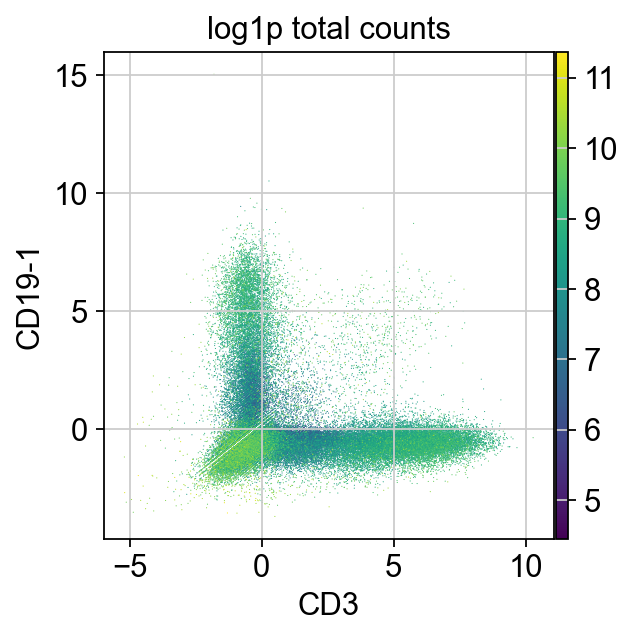

In [5]:
sc.pl.scatter(mdata["prot"], x="CD3", y="CD19-1", color="log1p_total_counts")

In this plot, we can see a large number of cells not expressing T or B cell markers in the lower left, cells expressing only one marker in the upper left and lower right as well as some cells expressing both markers (upper right).

The cells expressing both markers are most likely doublets and can be removed.

We can also use CD3 and CD14 to detect T/Monocytes doublets.

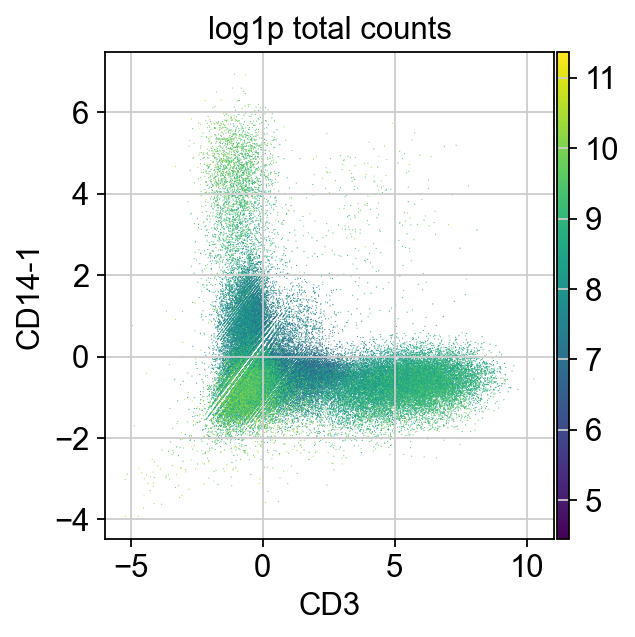

In [6]:
sc.pl.scatter(mdata["prot"], x="CD3", y="CD14-1", color="log1p_total_counts")

It looks like the change in distribution is around 2.5. We could use an expression level above 2.5 of at least two incompatible markers as our threshold to flag doublets.

In [7]:
genes2filter = ["CD3", "CD19-1", "CD14-1"]
temp = mdata["prot"][:, genes2filter].X.T.tolist()

In [8]:
mdata["prot"].obs["doublets_markers"] = [
    (temp[0][i] > 2.5 and temp[1][i] > 2.5) or (temp[0][i] > 2.5 and temp[2][i] > 2.5)
    for i in range(mdata.shape[0])
]
mdata["prot"].obs["doublets_markers"] = (
    mdata["prot"].obs["doublets_markers"].astype(str)
)

We leave out cells expressing both markers.

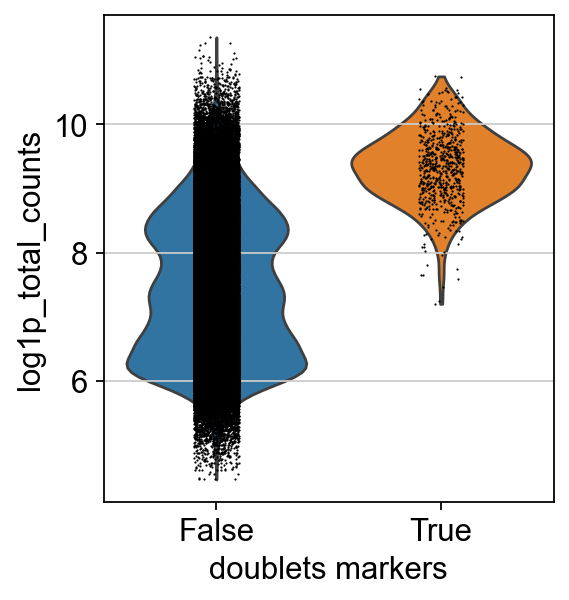

In [9]:
sc.pl.violin(mdata["prot"], keys="log1p_total_counts", groupby="doublets_markers")

Doublets usually have a higher count due to the presence of increased counts from more than one cell. We can see this effect in the cells classified as doublets using our markers.

In [10]:
mdata.update()

In [11]:
mdata = mdata[mdata.obs.loc[mdata["prot"].obs_names].index]

In [12]:
mdata = mdata[mdata["prot"].obs["doublets_markers"] == "False"].copy()

In [13]:
mdata

MuData object with n_obs × n_vars = 119837 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	119837 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	119837 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers', 'doublets_markers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'doublets_markers_colors'
      layers:	'counts'

In [14]:
mdata.write("cite_doublet_removal_xdbt.h5mu")

## References

```{bibliography}
:filter: docname in docnames
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Daniel Strobl
* Ciro Ramírez-Suástegui

### Reviewers

* Lukas Heumos
* Anna Schaar